In [25]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [4]:
def load_img(img_path):
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = tf.expand_dims(img, axis=0)
    return img

In [5]:
content_path = 'content_image.jpg'
style_path = 'style_image.jpg'

In [6]:
def show_img(img, title):
    if len(img.shape) > 3:
        img = tf.squeeze(img, axis=0)

    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")

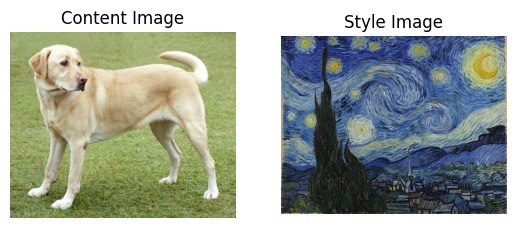

In [8]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
show_img(content_image, 'Content Image')
plt.subplot(1, 2, 2)
show_img(style_image, 'Style Image')
plt.show()

In [9]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [13]:
content_layers = ['block4_conv2', 'block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [14]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = []
  for name in layer_names:
    layer = vgg.get_layer(name)
    outputs.append(layer.output)

  model = tf.keras.Model(inputs=vgg.input, outputs=outputs)
  return model

In [16]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

In [17]:
def gram_matrix(tensor):
    shape = tf.shape(tensor)
    batch_size, height, width, channels = shape[0], shape[1], shape[2], shape[3]

    reshaped_tensor = tf.reshape(tensor, [batch_size, height*width, channels])

    gram = tf.matmul(reshaped_tensor, reshaped_tensor, transpose_a=True)
    
    num_locations = tf.cast(height*width, tf.float32)
    return gram/num_locations

In [18]:
class StyleContentExtractor(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.num_content_layers = len(content_layers)

        self.vgg = vgg_layers(style_layers + content_layers)

    def preprocess(self, image):
        image = image * 255.0
        return tf.keras.applications.vgg19.preprocess_input(image)

    def extract_style(self, outputs):
        style_outputs = outputs[:self.num_style_layers]
        return {
            name: gram_matrix(output)
            for name, output in zip(self.style_layers, style_outputs)
        }

    def extract_content(self, outputs):
        content_outputs = outputs[self.num_style_layers:]
        return {
            name: output
            for name, output in zip(self.content_layers, content_outputs)
        }

    def call(self, inputs):
        inputs = self.preprocess(inputs)
        outputs = self.vgg(inputs)
        style = self.extract_style(outputs)
        content = self.extract_content(outputs)
        return {'content': content, 'style': style}

In [19]:
extractor = StyleContentExtractor(style_layers, content_layers)

results = extractor(tf.constant(content_image))

In [22]:
style_targets = extractor(tf.constant(style_image))['style']
content_targets = results['content']

In [23]:
image = tf.Variable(content_image)

In [24]:
def clip_0_1(image):
  return tf.clip_by_value(image, 0.0, 1.0)

In [26]:
def tensor_to_image(tensor):
    image = tf.clip_by_value(tensor * 255.0, 0, 255)
    image = tf.cast(image, tf.uint8)
    if len(image.shape) == 4:
        image = tf.squeeze(image, axis=0)
    return Image.fromarray(image.numpy())